import libraries

In [1]:
from builtins import range, input

from keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from keras.models import Model, load_model
from keras.applications import InceptionV3
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob

use glob to grab images

In [3]:
#define paths
normalpath = 'D:\\dataset300\\normal'
covidpath = 'D:\\dataset300\\covid'
tbpath = 'D:\\dataset300\\tb'

# Use glob to grab images from path .jpg or jpeg
normal_files = glob(normalpath + '/*')
covid_files = glob(covidpath + '/*')
tb_files = glob(tbpath + '/*')

cv2 to read and resize images to 299x299 for InceptionV3

In [4]:
# Preparing Labels
normal_labels = []
covid_labels = []
tb_labels = []

normal_images=[]
covid_images=[]
tb_images=[]

import cv2

for i in range(len(normal_files)):
  image = cv2.imread(normal_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(299,299))
  normal_images.append(image)
  normal_labels.append(0)
for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(299,299))
  covid_images.append(image)
  covid_labels.append(1)
for i in range(len(tb_files)):
  image = cv2.imread(tb_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(299,299))
  tb_images.append(image)
  tb_labels.append(2)

In [5]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [6]:
x = np.concatenate((normal_images, covid_images, tb_images), axis=0)
y = np.concatenate((normal_labels, covid_labels, tb_labels), axis=0)

Split 80% training 20% testing

In [7]:
# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, stratify=y)

In [8]:
# make labels into categories - either 0 or 1
Y_train = to_categorical(y_train, num_classes=3)

Y_test = to_categorical(y_test, num_classes=3)

Load model

In [9]:
inception = InceptionV3(weights="imagenet", include_top=False, classes=3,
    input_tensor=Input(shape=(299, 299, 3)))

outputs = inception.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(3, activation="softmax")(outputs)

model = Model(inputs=inception.input, outputs=outputs)

for layer in inception.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

In [ ]:
model.summary()

Fit training data into model

In [10]:
history = model.fit(x_train, Y_train)

23/23 [==============================] - 124s 5s/step - loss: 202.6873 - accuracy: 0.6375


In [ ]:
model.save('inceptionv3.h5')

In [ ]:
model.save_weights('inceptionv3.hdf5')

In [ ]:
model = load_model('inceptionv3.h5')

In [11]:
y_pred = model.predict(x_test)

6/6 [==============================] - 30s 4s/step


In [12]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(Y_test, axis=1)

Text(0.5, 1.0, 'Confusion Matrix Transfer Learning InceptionV3')

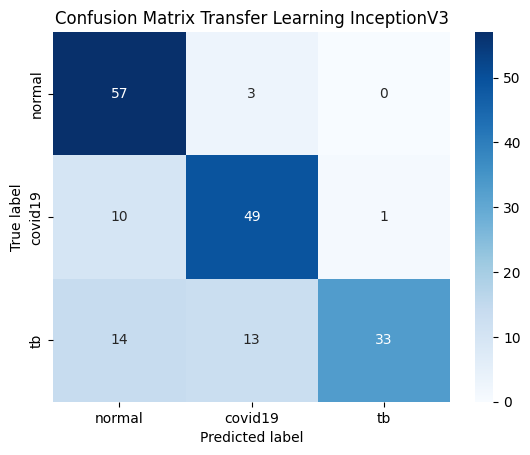

In [14]:
cm = confusion_matrix(y_test_bin, y_pred_bin)
classes=['normal', 'covid19', 'tb']
sns.heatmap(cm, annot=True, xticklabels=classes, yticklabels=classes,cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix Transfer Learning InceptionV3')

In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.70      0.95      0.81        60
           1       0.75      0.82      0.78        60
           2       0.97      0.55      0.70        60

    accuracy                           0.77       180
   macro avg       0.81      0.77      0.76       180
weighted avg       0.81      0.77      0.76       180



In [16]:
#plot roc multiclass
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from keras.utils import to_categorical

In [17]:
# Binarize the output
pred = to_categorical(y_pred_bin, num_classes=3)
n_classes = 3
ytest = to_categorical(y_test_bin, num_classes=3)

In [18]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
       fpr[i], tpr[i], _ = roc_curve(ytest[:,i], pred[:,i])
       roc_auc[i] = auc(fpr[i], tpr[i])

C:\Users\Zul\AppData\Local\Temp\ipykernel_9712\3692194127.py:7: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--',linestyle='--')


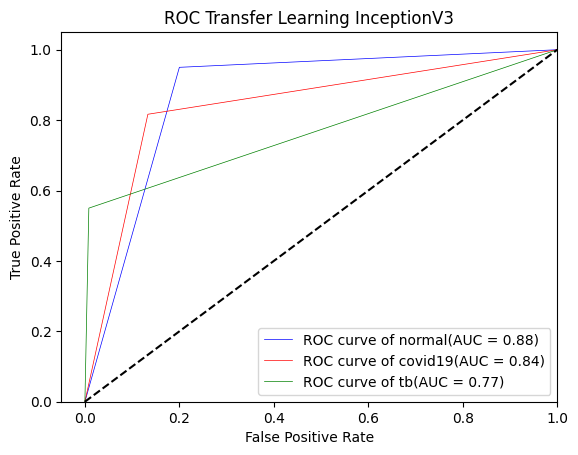

In [19]:
colors = ['blue', 'red', 'green']
cls = {0:'normal', 1:'covid19', 2:'tb'}
for i, color ,c in zip(range(n_classes), colors, cls.values()):
    plt.plot(fpr[i], tpr[i], color=color, lw=0.5,
             label='ROC curve of '+c+ '(AUC = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--',linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Transfer Learning InceptionV3')
plt.legend(loc="lower right")
plt.show()